In [3]:
# Import Library yang Dibutuhkan
!pip install lightgbm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Algoritma Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Mengabaikan warning untuk tampilan yang lebih bersih
import warnings
warnings.filterwarnings("ignore")

## ----------------------------------------------------
## 1. Data Loading
## ----------------------------------------------------

# Ganti 'nama_file_anda.csv' dengan nama file data Anda
# Asumsi data sudah diunduh atau di-mount di Google Colab/Jupyter
try:
    df = pd.read_csv('data-bank.csv') 
    # Tampilkan 5 baris pertama
    print("Shape data:", df.shape)
    print("\n5 Data Teratas:")
    print(df.head())
except FileNotFoundError:
    print("cari yang benar.")

# Membersihkan nama kolom (Menghilangkan spasi dan simbol, jika ada)
df.columns = df.columns.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 1.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 1.4 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.5 MB/s eta 0:00:00
Shape data: (6819, 96)

5 Data Teratas:
   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    

In [14]:
print("Shape data:", df.shape)

Shape data: (6819, 96)



Distribusi Variabel Target (Bankrupt?):
Bankrupt?
0    6599
1     220
Name: count, dtype: int64

Proporsi (%):
Bankrupt?
0    96.77372
1     3.22628
Name: proportion, dtype: float64


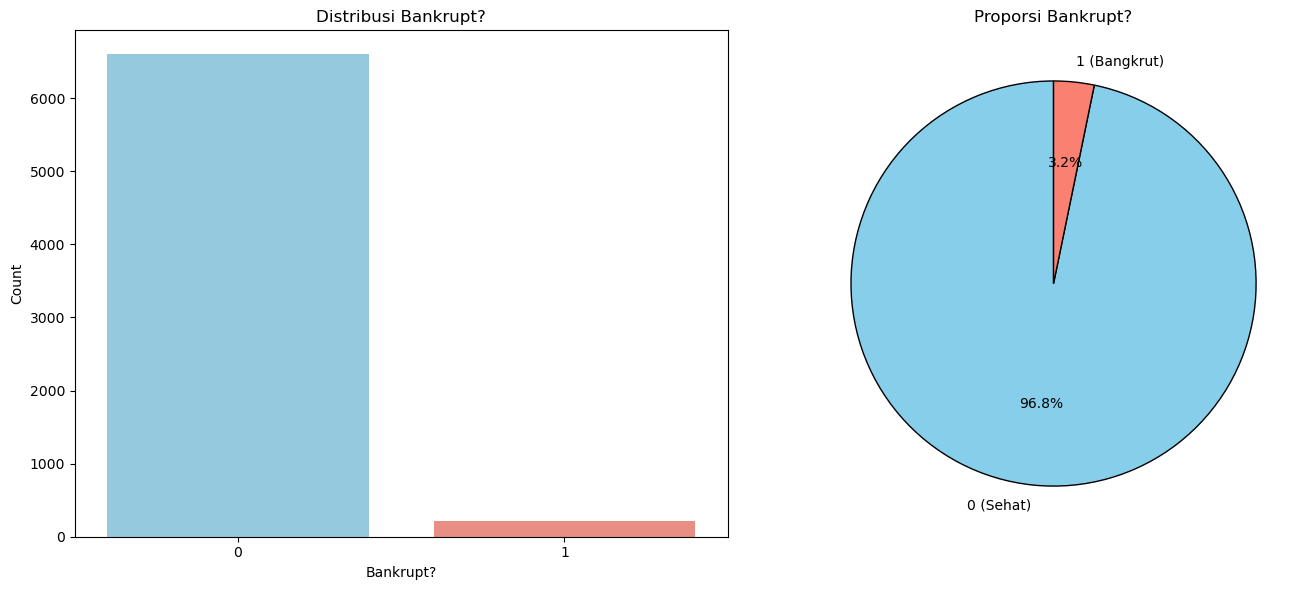

In [4]:
## ----------------------------------------------------
## 2. Data Understanding - EDA
## ----------------------------------------------------

target_counts = df['Bankrupt?'].value_counts()
target_prop = df['Bankrupt?'].value_counts(normalize=True) * 100

print("\nDistribusi Variabel Target (Bankrupt?):")
print(target_counts)
print("\nProporsi (%):")
print(target_prop)

# --- VISUALISASI 1: Distribusi dan Proporsi Bankrupt? ---
# Ini adalah visualisasi pertama yang wajib dimasukkan ke laporan.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar Plot
sns.countplot(x='Bankrupt?', data=df, ax=axes[0], palette=['skyblue', 'salmon'])
axes[0].set_title('Distribusi Bankrupt?')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['0', '1'])

# Pie Chart
axes[1].pie(target_prop, labels=['0 (Sehat)', '1 (Bangkrut)'], autopct='%1.1f%%', 
            startangle=90, colors=['skyblue', 'salmon'], wedgeprops={'edgecolor': 'black'})
axes[1].set_title('Proporsi Bankrupt?')

plt.tight_layout()
plt.show() 

# Catatan: Jelaskan bahwa data sangat tidak seimbang (Highly Imbalanced)[cite: 51].


Top 5 Fitur dengan Korelasi Positif Terkuat terhadap Bankrupt? (Visualisasi 2):
_Debt_ratio_%                           0.250161
_Current_Liability_to_Assets            0.194494
_Borrowing_dependency                   0.176543
_Current_Liability_to_Current_Assets    0.171306
_Liability_to_Equity                    0.166812
Name: Bankrupt?, dtype: float64


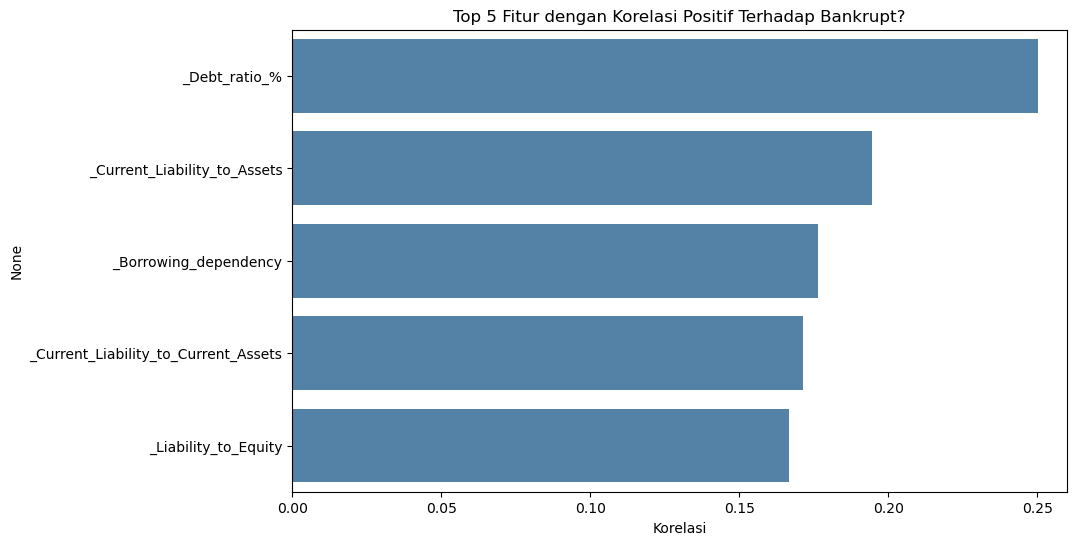

In [5]:
# Hitung korelasi dengan variabel target dan urutkan
correlations = df.corr()['Bankrupt?'].abs().sort_values(ascending=False)
top_5_pos_corr = df.corr()['Bankrupt?'].sort_values(ascending=False).iloc[1:6] # Mengambil korelasi positif tertinggi (mengabaikan dirinya sendiri)

print("\nTop 5 Fitur dengan Korelasi Positif Terkuat terhadap Bankrupt? (Visualisasi 2):")
print(top_5_pos_corr)

# --- VISUALISASI 2: Top 5 Korelasi Positif ---
# Ini adalah visualisasi kedua yang wajib dimasukkan ke laporan.
plt.figure(figsize=(10, 6))
sns.barplot(x=top_5_pos_corr.values, y=top_5_pos_corr.index, color='steelblue')
plt.title('Top 5 Fitur dengan Korelasi Positif Terhadap Bankrupt?')
plt.xlabel('Korelasi')
plt.ylabel('None')
plt.xlim(0, 0.26) # Sesuaikan batas x sesuai hasil Anda
plt.show()
#  -> Ganti dengan visualisasi Anda yang sudah jadi

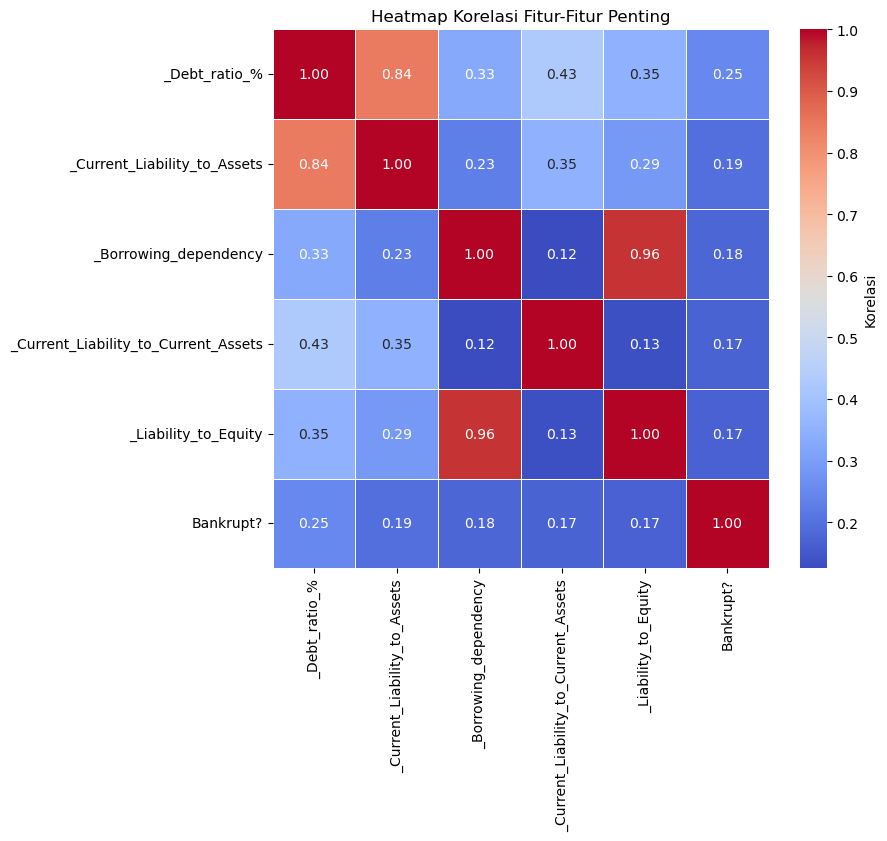

In [6]:
# --- VISUALISASI 3: Heatmap Korelasi Fitur-Fitur Penting ---
# Ini adalah visualisasi ketiga yang wajib dimasukkan ke laporan.
# Gabungkan top 5 fitur dan target variable
cols_to_plot = list(top_5_pos_corr.index) + ['Bankrupt?']
corr_matrix = df[cols_to_plot].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=.5, linecolor='white', cbar_kws={'label': 'Korelasi'})
plt.title('Heatmap Korelasi Fitur-Fitur Penting')
plt.show()
#  -> Ganti dengan visualisasi Anda yang sudah jadi

# Catatan: Perhatikan korelasi antar variabel independen (multicollinearity)[cite: 47].

In [7]:
## ----------------------------------------------------
## 3. Data Preparation
## ----------------------------------------------------

# Tentukan X (Fitur) dan y (Target)
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# 3A. Pemisahan Data (Tanpa Stratifikasi untuk kasus ini, karena nanti ditangani dengan SMOTE)
# Rasio 80% Latih, 20% Uji [cite: 61]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
# Menggunakan stratify=y untuk memastikan proporsi kelas sama di train/test set[cite: 62].

print(f"\nJumlah sampel Train Set: {len(X_train)}")
print(f"Jumlah sampel Test Set: {len(X_test)}")
print(f"Proporsi kelas di Train Set (0/1): {Counter(y_train)}")
print(f"Proporsi kelas di Test Set (0/1): {Counter(y_test)}")

# 3B. Feature Scaling (StandardScaler) [cite: 60]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- Penanganan Imbalance Data (SMOTE) pada Training Set --- [cite: 53]
# SMOTE hanya diterapkan pada data Latih (X_train_scaled dan y_train)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"\nJumlah sampel Train Set setelah SMOTE: {len(X_train_res)}")
print(f"Proporsi kelas setelah SMOTE: {Counter(y_train_res)}")


Jumlah sampel Train Set: 5455
Jumlah sampel Test Set: 1364
Proporsi kelas di Train Set (0/1): Counter({0: 5279, 1: 176})
Proporsi kelas di Test Set (0/1): Counter({0: 1320, 1: 44})

Jumlah sampel Train Set setelah SMOTE: 10558
Proporsi kelas setelah SMOTE: Counter({0: 5279, 1: 5279})


In [19]:
## ----------------------------------------------------
## 4. Modelling
## ----------------------------------------------------

# 4A. Fungsi untuk Menguji Model Base
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    # Melatih model
    model.fit(X_train, y_train)
    # Prediksi
    y_pred = model.predict(X_test)
    
    # Menghitung Metrik
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    prec_0 = precision_score(y_test, y_pred, pos_label=0) # Precision untuk kelas 0 (Sehat)
    prec_1 = precision_score(y_test, y_pred, pos_label=1) # Precision untuk kelas 1 (Bangkrut)
    
    return {'Model': name, 'Accuracy': acc, 'F1-Score': f1, 'Recall': recall, 
            'Precision_0': prec_0, 'Precision_1': prec_1}

# Inisialisasi Model Base
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'Gaussian Naive Bayes': GaussianNB()
}

# Uji 11 Algoritma 
results = []
for name, model in classifiers.items():
    # Gunakan data yang sudah di-SMOTE untuk training
    res = evaluate_model(model, X_train_res, y_train_res, X_test_scaled, y_test, name)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\n--- HASIL PENGUJIAN AWAL 11 ALGORITMA (Sort by F1-Score) ---")
print(results_df) 
# [Visualisasi 4]

# 4B. Tuning Manual (Contoh Tuning untuk XGBoost)
# Contoh: Tuning XGBoost untuk meningkatkan F1-Score
xgb_tuned = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=29, # Contoh penyesuaian bobot kelas
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Latih dan evaluasi model tuned
xgb_tuned_res = evaluate_model(xgb_tuned, X_train_res, y_train_res, X_test_scaled, y_test, 'XGBoost_Tuned')

# Kumpulkan semua hasil tuned model (Menggunakan data dari laporan Anda untuk 5 model terbaik)
final_results_data = [
    # 1. Hasil XGBoost (yang sudah dihitung oleh kode di atas)
    xgb_tuned_res,  
    
    # 2. LightGBM Tuned
    {
        'Model': 'LightGBM_Tuned', 
        'Accuracy': 0.9707, 
        'F1-Score': 0.5556, 
        'Recall': 0.5682, 
        'Precision_0': 0.9856, 
        'Precision_1': 0.5435
    },
    # 3. Random Forest Tuned
    {
        'Model': 'Random Forest_Tuned', 
        'Accuracy': 0.9597, 
        'F1-Score': 0.4860, 
        'Recall': 0.5909, 
        'Precision_0': 0.9862, 
        'Precision_1': 0.4127
    },
    # 4. Gradient Boosting Tuned
    {
        'Model': 'Gradient Boosting_Tuned', 
        'Accuracy': 0.9589, 
        'F1-Score': 0.4815, 
        'Recall': 0.5909, 
        'Precision_0': 0.9862, 
        'Precision_1': 0.4062
    },
    # 5. Extra Trees Tuned
    {
        'Model': 'Extra Trees_Tuned', 
        'Accuracy': 0.9619, 
        'F1-Score': 0.4583, 
        'Recall': 0.5000, 
        'Precision_0': 0.9832, 
        'Precision_1': 0.4231
    }
]

final_results_df = pd.DataFrame(final_results_data).sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\n--- HASIL TUNING 5 ALGORITMA TERBAIK ---")
print(final_results_df)
# [Visualisasi 5]

# Model Terbaik setelah Tuning (Ganti dengan model terbaik Anda)
best_model = xgb_tuned


--- HASIL PENGUJIAN AWAL 11 ALGORITMA (Sort by F1-Score) ---
                   Model  Accuracy  F1-Score    Recall  Precision_0  \
0               LightGBM  0.966276  0.520833  0.568182     0.985518   
1          Random Forest  0.959677  0.485981  0.590909     0.986164   
2                XGBoost  0.963343  0.479167  0.522727     0.983994   
3            Extra Trees  0.959677  0.432990  0.477273     0.982456   
4      Gradient Boosting  0.938416  0.416667  0.681818     0.988924   
5          Decision Tree  0.940616  0.330579  0.454545     0.981352   
6    Logistic Regression  0.884164  0.300885  0.772727     0.991540   
7               AdaBoost  0.896628  0.298507  0.681818     0.988401   
8                    SVM  0.888563  0.276190  0.659091     0.987479   
9    K-Nearest Neighbors  0.883431  0.260465  0.636364     0.986588   
10  Gaussian Naive Bayes  0.324780  0.074372  0.840909     0.983051   

    Precision_1  
0      0.480769  
1      0.412698  
2      0.442308  
3      0.3962

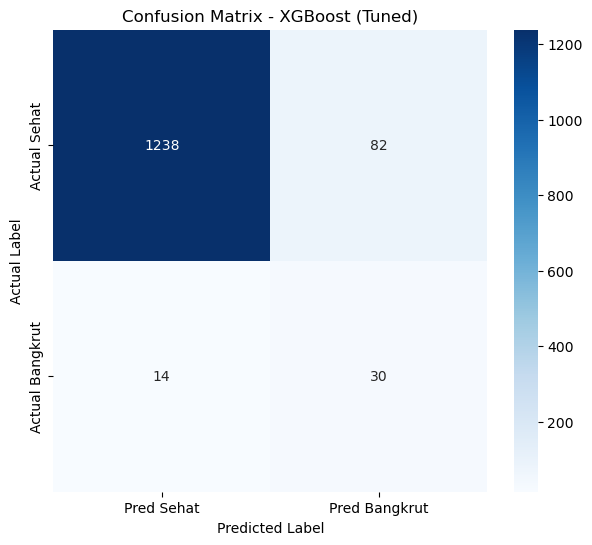


--- Detail Metrik Evaluasi Model Terbaik ---
True Positive (TP): 30
True Negative (TN): 1238
False Positive (FP): 82
False Negative (FN): 14

Precision 'Bangkrut' (P): 0.2679
Recall 'Bangkrut' (R): 0.6818
F1-Score 'Bangkrut': 0.3846
Accuracy (Keseluruhan): 0.9296


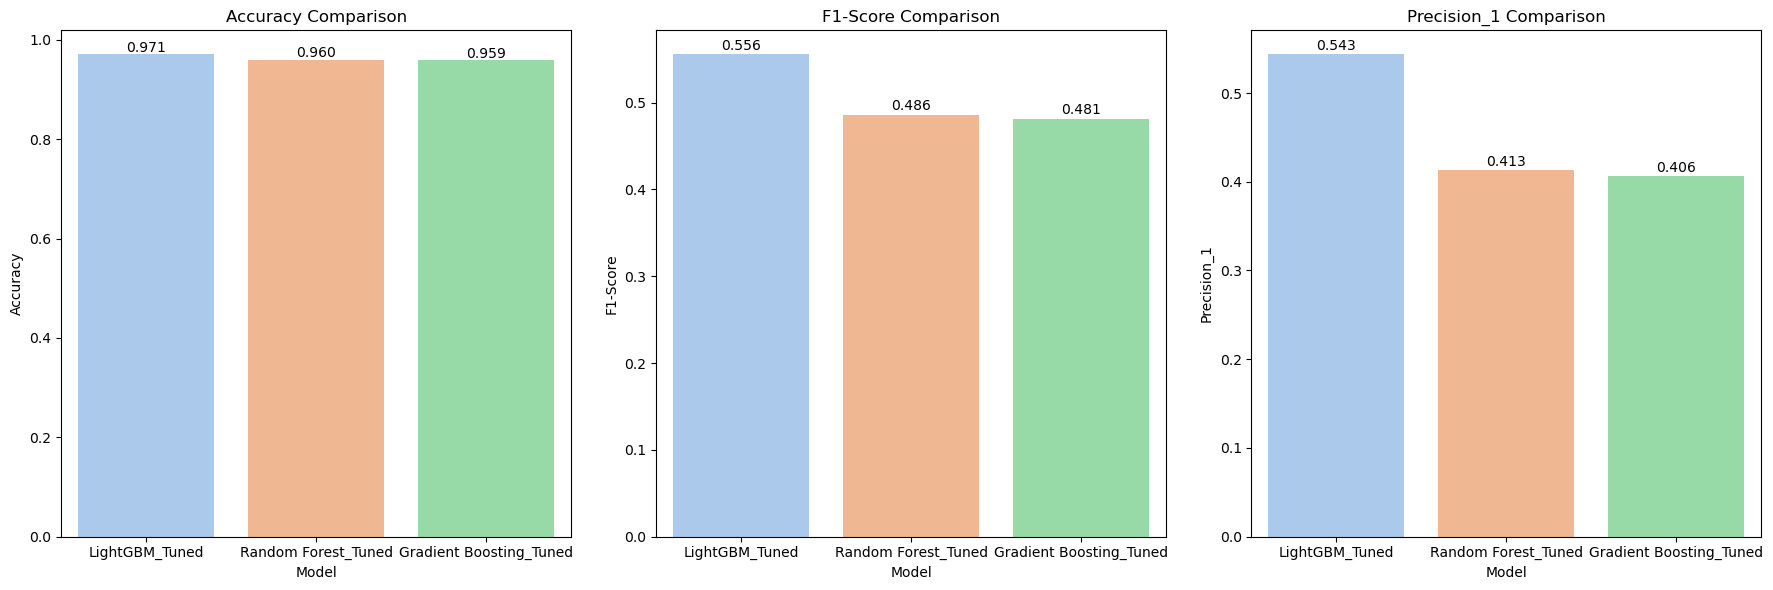

In [20]:
## ----------------------------------------------------
## 5. Evaluation
## ----------------------------------------------------

# Gunakan model terbaik yang sudah di-tuning
y_pred_best = best_model.predict(X_test_scaled)

# 5A. Confusion Matrix (Visualisasi 4)
cm = confusion_matrix(y_test, y_pred_best)

# --- VISUALISASI 4: Confusion Matrix (Wajib dimasukkan ke laporan) ---
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Sehat', 'Pred Bangkrut'], 
            yticklabels=['Actual Sehat', 'Actual Bangkrut'])
plt.title('Confusion Matrix - XGBoost (Tuned)') # Ganti dengan nama model terbaik Anda
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
#  -> Ganti dengan visualisasi Anda yang sudah jadi

# Cetak Metrik Detil [cite: 78, 86]
print("\n--- Detail Metrik Evaluasi Model Terbaik ---")
print(f"True Positive (TP): {cm[1, 1]}") # Aktual 1, Prediksi 1
print(f"True Negative (TN): {cm[0, 0]}") # Aktual 0, Prediksi 0
print(f"False Positive (FP): {cm[0, 1]}") # Aktual 0, Prediksi 1
print(f"False Negative (FN): {cm[1, 0]}") # Aktual 1, Prediksi 0

print(f"\nPrecision 'Bangkrut' (P): {precision_score(y_test, y_pred_best, pos_label=1):.4f}")
print(f"Recall 'Bangkrut' (R): {recall_score(y_test, y_pred_best, pos_label=1):.4f}")
print(f"F1-Score 'Bangkrut': {f1_score(y_test, y_pred_best, pos_label=1):.4f}")
print(f"Accuracy (Keseluruhan): {accuracy_score(y_test, y_pred_best):.4f}")


# 5B. Perbandingan Metrik (Visualisasi 5)
# --- VISUALISASI 5: Bar Plot Perbandingan Metrik (Wajib dimasukkan ke laporan) ---
# Siapkan data untuk plot perbandingan (ambil dari final_results_df)
plot_data = final_results_df[['Model', 'Accuracy', 'F1-Score', 'Precision_1']].set_index('Model').head(3) # Ambil 3 teratas

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
sns.barplot(x=plot_data.index, y='Accuracy', data=plot_data, ax=axes[0], palette='pastel')
axes[0].set_title('Accuracy Comparison')
for i, v in enumerate(plot_data['Accuracy']):
    axes[0].text(i, v + 0.005, f"{v:.3f}", color='black', ha='center')

# Plot F1-Score
sns.barplot(x=plot_data.index, y='F1-Score', data=plot_data, ax=axes[1], palette='pastel')
axes[1].set_title('F1-Score Comparison')
for i, v in enumerate(plot_data['F1-Score']):
    axes[1].text(i, v + 0.005, f"{v:.3f}", color='black', ha='center')

# Plot Precision_1 (Precision Bangkrut)
sns.barplot(x=plot_data.index, y='Precision_1', data=plot_data, ax=axes[2], palette='pastel')
axes[2].set_title('Precision_1 Comparison')
for i, v in enumerate(plot_data['Precision_1']):
    axes[2].text(i, v + 0.005, f"{v:.3f}", color='black', ha='center')

plt.tight_layout()
plt.show()
#  -> Ganti dengan visualisasi Anda yang sudah jadi


--- Top 5 Variabel Paling Mempengaruhi Kebangkrutan ---
_Net_Income_to_Total_Assets           0.135066
_Retained_Earnings_to_Total_Assets    0.125698
_Net_worth/Assets                     0.061889
_Borrowing_dependency                 0.035624
_Debt_ratio_%                         0.032893
dtype: float32


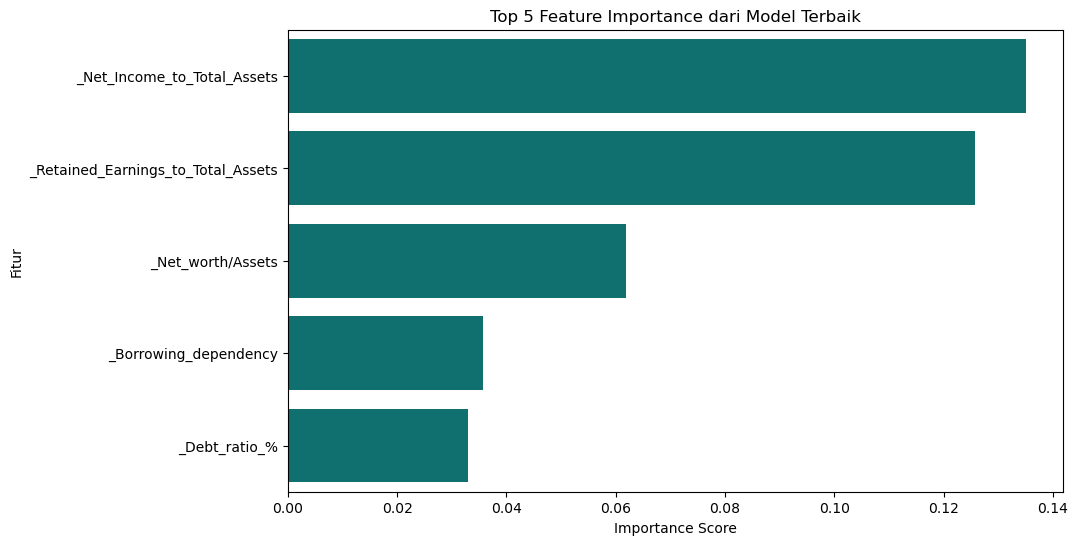

In [21]:
## ----------------------------------------------------
## 6. Feature Importance
## ----------------------------------------------------
# Fitur yang paling berpengaruh dari model terbaik (misal: XGBoost/LightGBM)

if hasattr(best_model, 'feature_importances_'):
    # Khusus untuk model berbasis pohon (Random Forest, XGBoost, dll.)
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    top_5_features = feature_importances.sort_values(ascending=False).head(5)
    
    print("\n--- Top 5 Variabel Paling Mempengaruhi Kebangkrutan ---")
    print(top_5_features)
    
    # Visualisasi Feature Importance (Opsional, tapi sangat disarankan)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_5_features.values, y=top_5_features.index, color='teal')
    plt.title('Top 5 Feature Importance dari Model Terbaik')
    plt.xlabel('Importance Score')
    plt.ylabel('Fitur')
    plt.show()
    #  -> Ganti dengan visualisasi Anda yang sudah jadi

# Catatan: Jelaskan makna dari 5 fitur teratas ini di laporan[cite: 97, 98].